# MLP
MLP, K=5, lncRNA.

Droput.

In [79]:
from datetime import datetime
print(datetime.now())

2023-04-06 19:42:54.356343


In [80]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [81]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
#from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.optimizers import SGD
#from keras.losses import Hinge

K=3
ALPHABET=4**K + 1
RCELLS=32
DCELLS=16
EPOCHS=10 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000 # NOT USED FOR MLP
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

Python 3.9.16
sklearn 1.2.2


In [82]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # 'test.canon_lncRNA_transcripts.csv'

In [83]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [84]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN) # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # No MAXLEN for MLP
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [85]:
def build_model():
    CFILTERS=64   # 64 was overfitting 
    FILTERSIZE=8
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn    = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop1_layer = Dropout(0.5)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop2_layer = Dropout(0.5)
    flat_layer = Flatten()
    dens_layer = Dense(32,activation='sigmoid')
    drop3_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool1_layer)
    cnn.add(drop1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool2_layer)
    cnn.add(drop2_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop3_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [86]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-06 19:42:56.039522
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 4998, 4)           260       
                                                                 
 conv1d_72 (Conv1D)          (None, 4991, 64)          2112      
                                                                 
 max_pooling1d_72 (MaxPoolin  (None, 1246, 64)         0         
 g1D)                                                            
                                                                 
 dropout_93 (Dropout)        (None, 1246, 64)          0         
                                                                 
 conv1d_73 (Conv1D)          (None, 1239, 64)          32832     
                                                                 
 max_pooling1d_73 (MaxPoolin  (None, 308, 64)          0         
 g1D)                     

## Training

In [87]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        #cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        #cwd = {0: cw[0], 1: cw[1]}
        #print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            )  # no validation # class_weight=cwd)
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            validation_data=(X_valid,y_valid) ) # class_weight=cwd, 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Correct scores pos:neg',correct_pos,correct_neg)  
        print('Wrong scores pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [88]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-06 19:42:56.249138
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.

Training # 1 1
2023-04-06 19:43:02.219251
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-06 19:43:02.230709
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Valid 1:0 458:412 52.64%
FIT
2023-04-06 19:43:03.618277


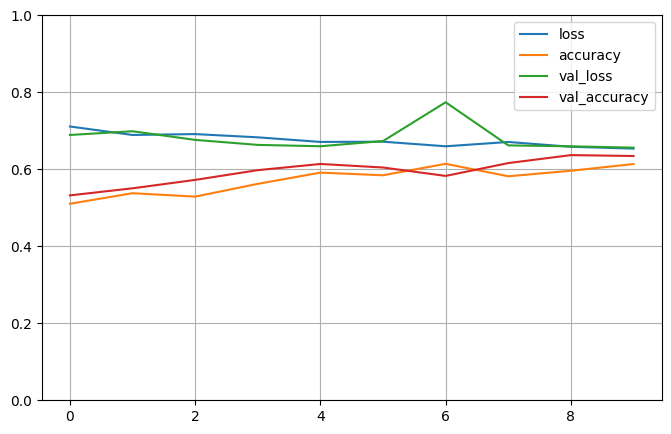


Testing # 1 1
2023-04-06 19:43:22.570111
2023-04-06 19:43:22.570147
PREDICT
2023-04-06 19:43:22.796225
Test 1:0 458:412 52.64%
Predict 1:0 504:366 57.93%
Test sizes (870, 4998) (870,)
Distrib of scores: 0.5177941 mean 0.10904069 std
Range of scores: 0.10363626 to 0.7295265
Score threshold 0.5
Confusion matrix
 [[230 182]
 [136 322]]
Normalized matrix
 [[0.26436782 0.2091954 ]
 [0.15632184 0.37011494]]
Correct scores pos:neg 77 39
Wrong scores pos:neg 38 15


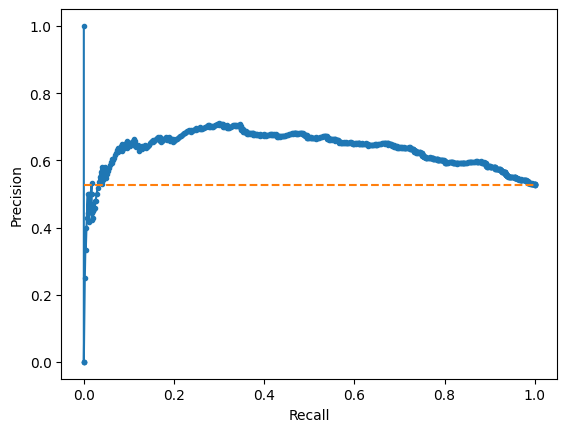

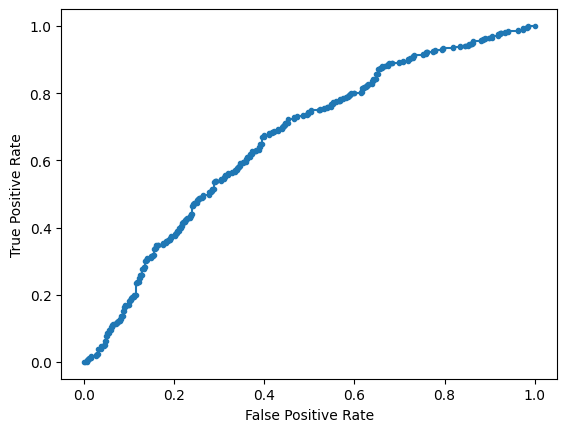

Accuracy: 63.45% Precision: 63.89% Recall: 70.31%
F1: 66.94% MCC: 0.2643
AUPRC: 63.31% AUROC: 66.06%
 accuracy [63.44827586206897]
 precision [63.888888888888886]
 recall [70.3056768558952]
 F1 [66.94386694386694]
 MCC [0.2642896947673029]
 AUPRC [63.31101841791919]
 AUROC [66.06499342858353]

Training # 1 2
2023-04-06 19:43:23.446006
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-06 19:43:23.464726
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Valid 1:0 442:442 50.00%
FIT
2023-04-06 19:43:24.700437


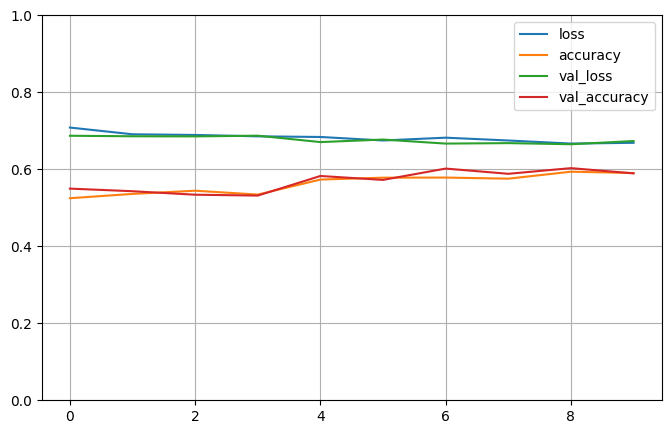


Testing # 1 2
2023-04-06 19:43:46.600538
2023-04-06 19:43:46.600583
PREDICT
2023-04-06 19:43:46.824512
Test 1:0 442:442 50.00%
Predict 1:0 625:259 70.70%
Test sizes (884, 4998) (884,)
Distrib of scores: 0.5177801 mean 0.14997989 std
Range of scores: 0.04173676 to 0.675297
Score threshold 0.5
Confusion matrix
 [[169 273]
 [ 90 352]]
Normalized matrix
 [[0.19117647 0.30882353]
 [0.10180995 0.39819005]]
Correct scores pos:neg 5 105
Wrong scores pos:neg 3 50


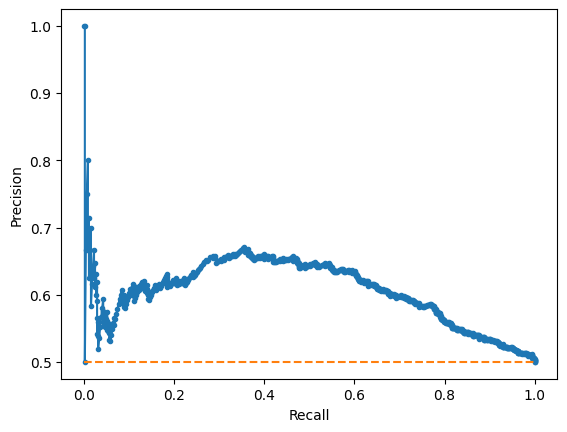

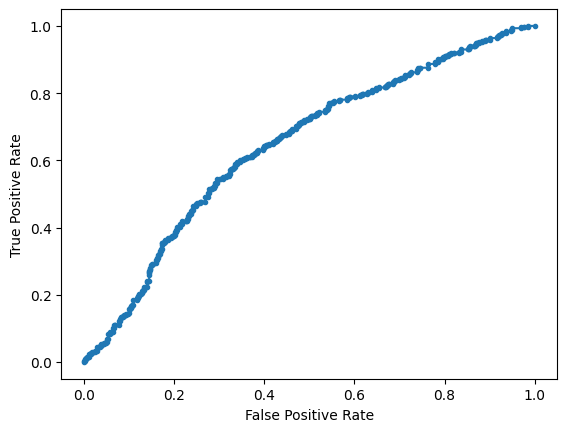

Accuracy: 58.94% Precision: 56.32% Recall: 79.64%
F1: 65.98% MCC: 0.1964
AUPRC: 60.57% AUROC: 64.51%
 accuracy [58.93665158371041]
 precision [56.32]
 recall [79.63800904977376]
 F1 [65.97938144329896]
 MCC [0.19635284605637923]
 AUPRC [60.57288377049963]
 AUROC [64.51495669621833]

Training # 1 3
2023-04-06 19:43:47.628303
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-06 19:43:47.649552
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Valid 1:0 442:407 52.06%
FIT
2023-04-06 19:43:48.904760


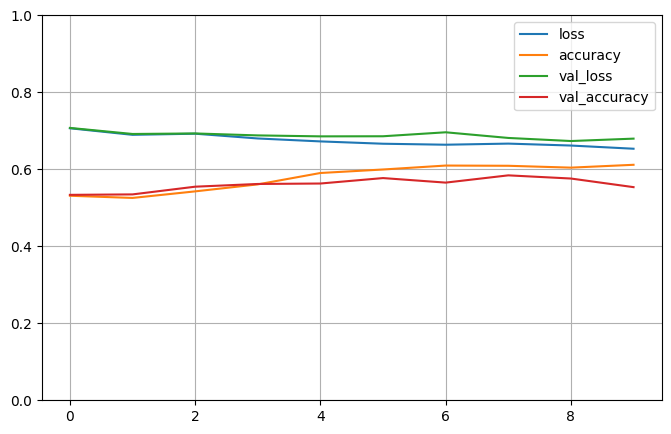


Testing # 1 3
2023-04-06 19:44:06.079170
2023-04-06 19:44:06.079530
PREDICT
2023-04-06 19:44:06.300860
Test 1:0 442:407 52.06%
Predict 1:0 291:558 34.28%
Test sizes (849, 4998) (849,)
Distrib of scores: 0.47171852 mean 0.10435714 std
Range of scores: 0.13931805 to 0.76980776
Score threshold 0.5
Confusion matrix
 [[293 114]
 [265 177]]
Normalized matrix
 [[0.3451119  0.13427562]
 [0.31213192 0.20848057]]
Correct scores pos:neg 44 48
Wrong scores pos:neg 29 23


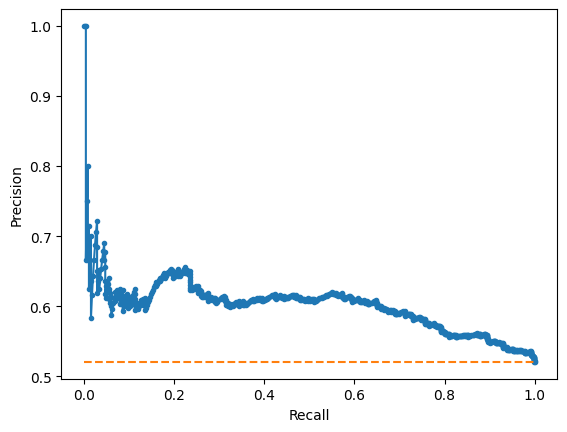

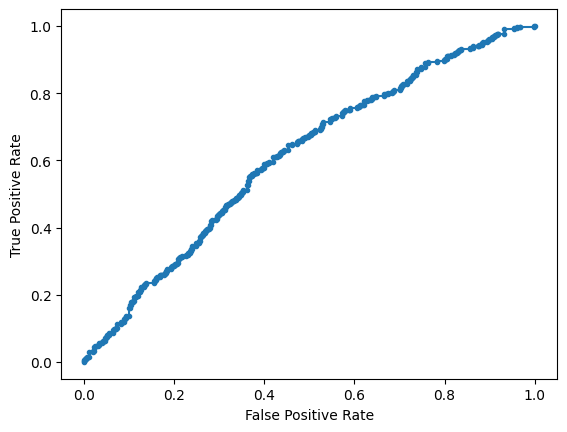

Accuracy: 55.36% Precision: 60.82% Recall: 40.05%
F1: 48.29% MCC: 0.1267
AUPRC: 60.15% AUROC: 61.01%
 accuracy [55.35924617196702]
 precision [60.824742268041234]
 recall [40.04524886877828]
 F1 [48.294679399727144]
 MCC [0.12667940847108874]
 AUPRC [60.15369075261769]
 AUROC [61.01315218962279]

Training # 1 4
2023-04-06 19:44:06.920301
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-06 19:44:06.940335
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Valid 1:0 459:431 51.57%
FIT
2023-04-06 19:44:08.227244


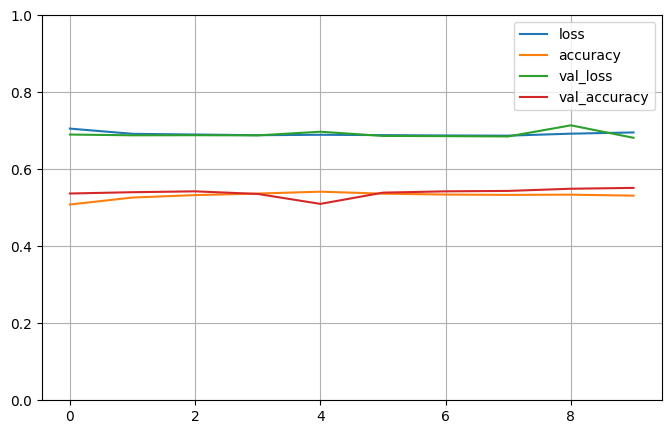


Testing # 1 4
2023-04-06 19:44:30.370584
2023-04-06 19:44:30.370630
PREDICT
2023-04-06 19:44:30.605182
Test 1:0 459:431 51.57%
Predict 1:0 806:84 90.56%
Test sizes (890, 4998) (890,)
Distrib of scores: 0.52227175 mean 0.03275747 std
Range of scores: 0.3928255 to 0.60441506
Score threshold 0.5
Confusion matrix
 [[ 58 373]
 [ 26 433]]
Normalized matrix
 [[0.06516854 0.41910112]
 [0.02921348 0.48651685]]
Correct scores pos:neg 0 0
Wrong scores pos:neg 0 0


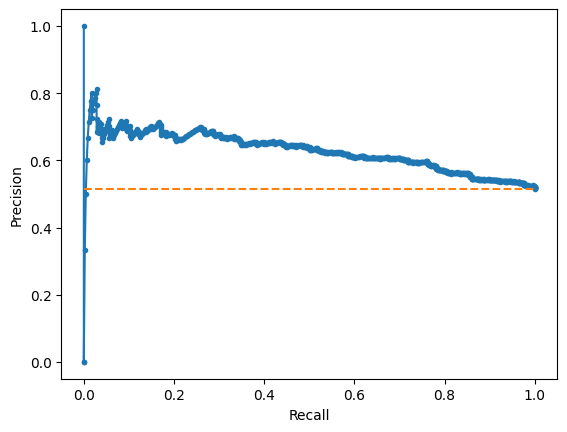

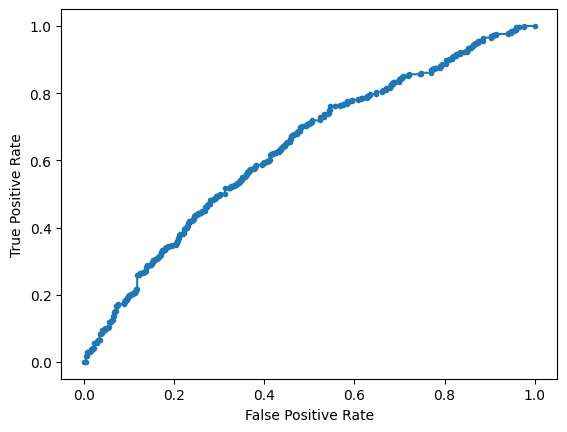

Accuracy: 55.17% Precision: 53.72% Recall: 94.34%
F1: 68.46% MCC: 0.1332
AUPRC: 62.65% AUROC: 63.53%
 accuracy [55.168539325842694]
 precision [53.72208436724566]
 recall [94.33551198257081]
 F1 [68.45849802371542]
 MCC [0.1332047034034013]
 AUPRC [62.65127387032181]
 AUROC [63.52986670306174]

Training # 1 5
2023-04-06 19:44:31.238943
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-06 19:44:31.259905
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Valid 1:0 457:419 52.17%
FIT
2023-04-06 19:44:32.489383


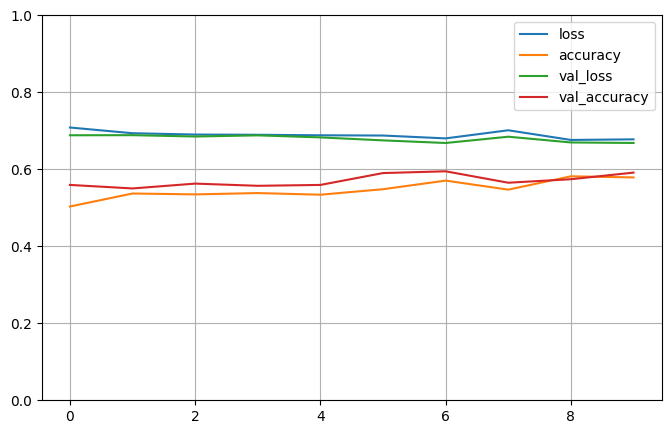


Testing # 1 5
2023-04-06 19:44:50.530423
2023-04-06 19:44:50.530732
PREDICT
2023-04-06 19:44:50.949638
Test 1:0 457:419 52.17%
Predict 1:0 523:353 59.70%
Test sizes (876, 4998) (876,)
Distrib of scores: 0.52971715 mean 0.117041394 std
Range of scores: 0.17609628 to 0.68487936
Score threshold 0.5
Confusion matrix
 [[207 212]
 [146 311]]
Normalized matrix
 [[0.23630137 0.24200913]
 [0.16666667 0.35502283]]
Correct scores pos:neg 152 31
Wrong scores pos:neg 72 9


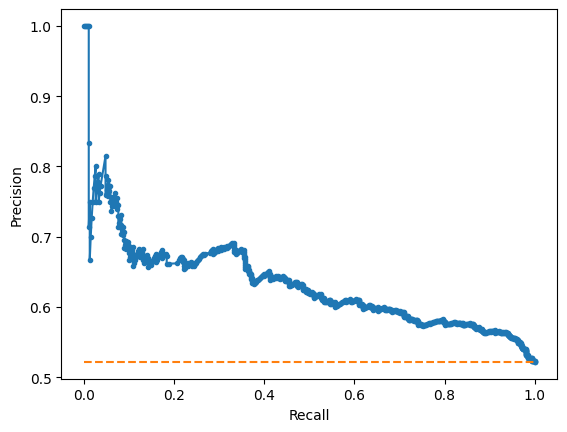

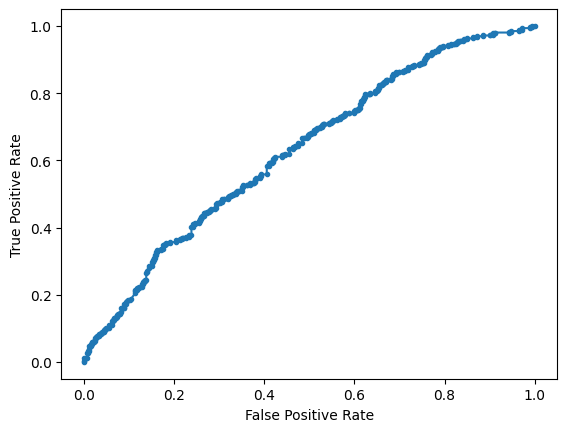

Accuracy: 59.13% Precision: 59.46% Recall: 68.05%
F1: 63.47% MCC: 0.1778
AUPRC: 63.28% AUROC: 63.03%
 accuracy [59.1324200913242]
 precision [59.46462715105163]
 recall [68.05251641137856]
 F1 [63.46938775510205]
 MCC [0.17777394389082452]
 AUPRC [63.2832282747261]
 AUROC [63.02726612806359]

Training # 2 1
2023-04-06 19:44:51.963587
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-06 19:44:51.984605
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Valid 1:0 472:415 53.21%
FIT
2023-04-06 19:44:53.448328


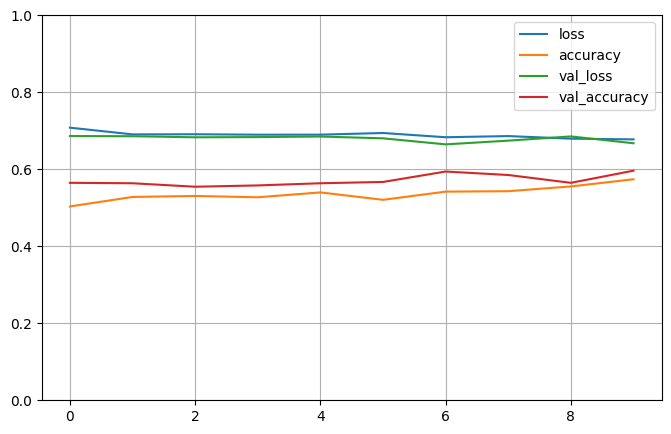


Testing # 2 1
2023-04-06 19:45:16.092867
2023-04-06 19:45:16.093237
PREDICT
2023-04-06 19:45:16.516446
Test 1:0 472:415 53.21%
Predict 1:0 622:265 70.12%
Test sizes (887, 4998) (887,)
Distrib of scores: 0.5156074 mean 0.092555165 std
Range of scores: 0.12106618 to 0.6035435
Score threshold 0.5
Confusion matrix
 [[161 254]
 [104 368]]
Normalized matrix
 [[0.18151071 0.28635851]
 [0.11724915 0.41488162]]
Correct scores pos:neg 0 48
Wrong scores pos:neg 0 16


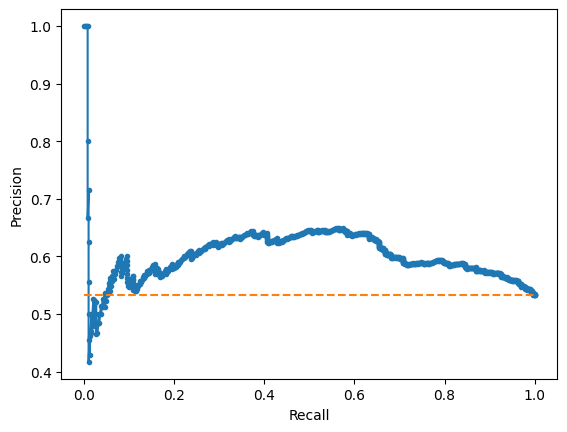

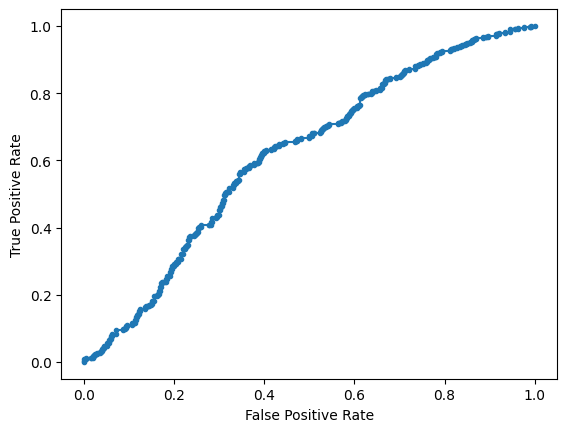

Accuracy: 59.64% Precision: 59.16% Recall: 77.97%
F1: 67.28% MCC: 0.1827
AUPRC: 60.13% AUROC: 61.63%
 accuracy [59.63923337091319]
 precision [59.163987138263664]
 recall [77.96610169491525]
 F1 [67.27605118829982]
 MCC [0.18271919032819847]
 AUPRC [60.12603783416349]
 AUROC [61.627016540739234]

Training # 2 2
2023-04-06 19:45:17.499581
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-06 19:45:17.525766
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Valid 1:0 452:416 52.07%
FIT
2023-04-06 19:45:19.616880


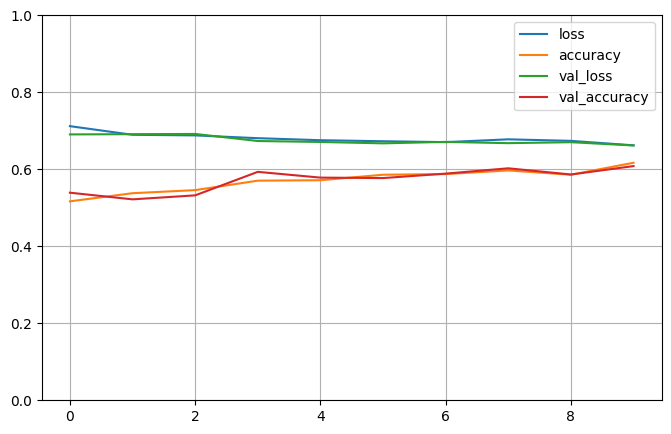


Testing # 2 2
2023-04-06 19:45:41.508191
2023-04-06 19:45:41.508225
PREDICT
2023-04-06 19:45:41.756285
Test 1:0 452:416 52.07%
Predict 1:0 622:246 71.66%
Test sizes (868, 4998) (868,)
Distrib of scores: 0.55639756 mean 0.116739236 std
Range of scores: 0.22053437 to 0.7298852
Score threshold 0.5
Confusion matrix
 [[161 255]
 [ 85 367]]
Normalized matrix
 [[0.18548387 0.2937788 ]
 [0.09792627 0.42281106]]
Correct scores pos:neg 142 49
Wrong scores pos:neg 70 19


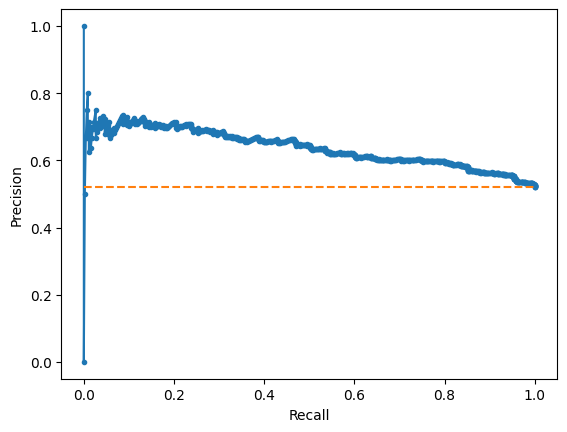

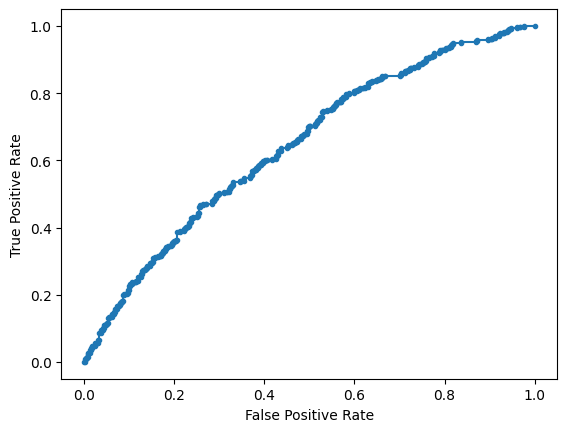

Accuracy: 60.83% Precision: 59.00% Recall: 81.19%
F1: 68.34% MCC: 0.2206
AUPRC: 63.67% AUROC: 64.41%
 accuracy [60.82949308755761]
 precision [59.0032154340836]
 recall [81.19469026548673]
 F1 [68.34264432029795]
 MCC [0.22056281556309065]
 AUPRC [63.674439802086034]
 AUROC [64.41084496255957]

Training # 2 3
2023-04-06 19:45:42.557636
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-06 19:45:42.579173
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Valid 1:0 453:407 52.67%
FIT
2023-04-06 19:45:44.684744


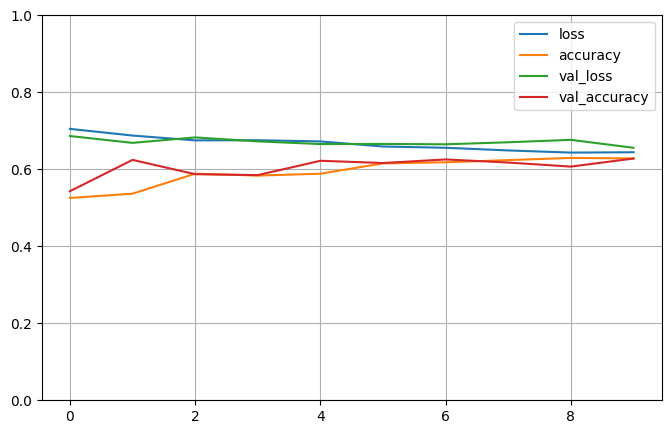


Testing # 2 3
2023-04-06 19:46:06.999246
2023-04-06 19:46:06.999285
PREDICT
2023-04-06 19:46:07.221719
Test 1:0 453:407 52.67%
Predict 1:0 563:297 65.47%
Test sizes (860, 4998) (860,)
Distrib of scores: 0.53131586 mean 0.15859777 std
Range of scores: 0.0788639 to 0.72425807
Score threshold 0.5
Confusion matrix
 [[192 215]
 [105 348]]
Normalized matrix
 [[0.22325581 0.25      ]
 [0.12209302 0.40465116]]
Correct scores pos:neg 180 100
Wrong scores pos:neg 86 43


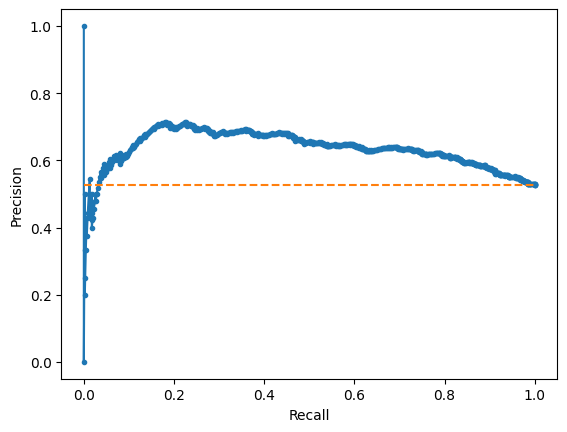

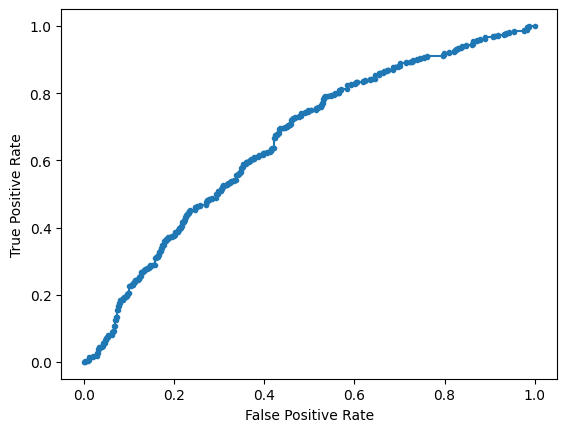

Accuracy: 62.79% Precision: 61.81% Recall: 76.82%
F1: 68.50% MCC: 0.2520
AUPRC: 63.28% AUROC: 65.71%
 accuracy [62.7906976744186]
 precision [61.811722912966246]
 recall [76.82119205298014]
 F1 [68.50393700787401]
 MCC [0.25196847487090707]
 AUPRC [63.27732322076734]
 AUROC [65.71098491628294]

Training # 2 4
2023-04-06 19:46:07.873243
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-06 19:46:07.894685
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Valid 1:0 432:447 49.15%
FIT
2023-04-06 19:46:09.201597


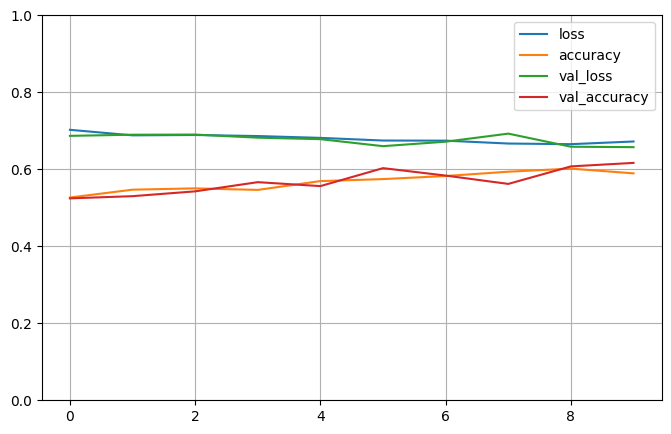


Testing # 2 4
2023-04-06 19:46:27.974642
2023-04-06 19:46:27.974682
PREDICT
2023-04-06 19:46:28.193540
Test 1:0 432:447 49.15%
Predict 1:0 535:344 60.86%
Test sizes (879, 4998) (879,)
Distrib of scores: 0.511035 mean 0.10033609 std
Range of scores: 0.22222382 to 0.7087451
Score threshold 0.5
Confusion matrix
 [[227 220]
 [117 315]]
Normalized matrix
 [[0.25824801 0.25028441]
 [0.1331058  0.35836177]]
Correct scores pos:neg 54 45
Wrong scores pos:neg 25 20


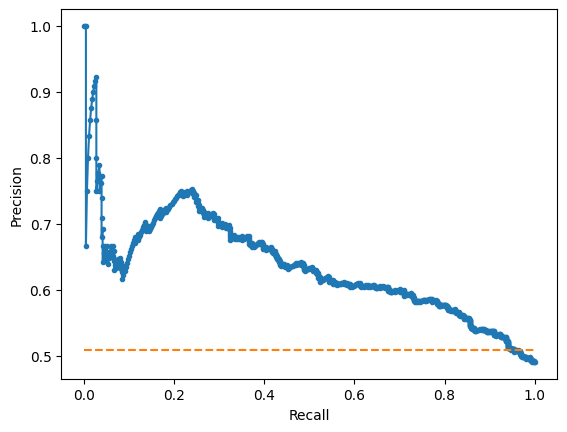

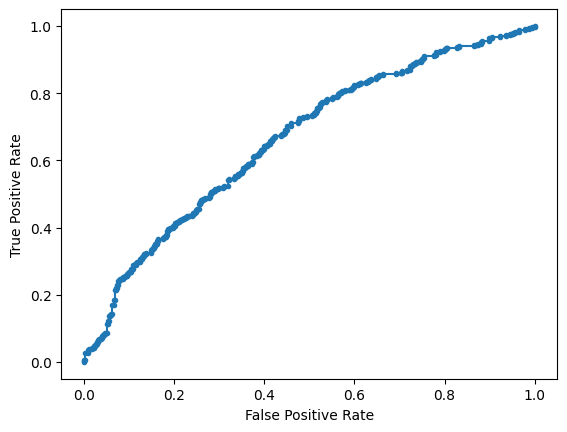

Accuracy: 61.66% Precision: 58.88% Recall: 72.92%
F1: 65.15% MCC: 0.2428
AUPRC: 63.52% AUROC: 66.30%
 accuracy [61.66097838452787]
 precision [58.87850467289719]
 recall [72.91666666666666]
 F1 [65.14994829369184]
 MCC [0.2427625660522635]
 AUPRC [63.518362563107324]
 AUROC [66.29536415610242]

Training # 2 5
2023-04-06 19:46:28.855384
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-06 19:46:28.878547
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Valid 1:0 449:426 51.31%
FIT
2023-04-06 19:46:30.196184


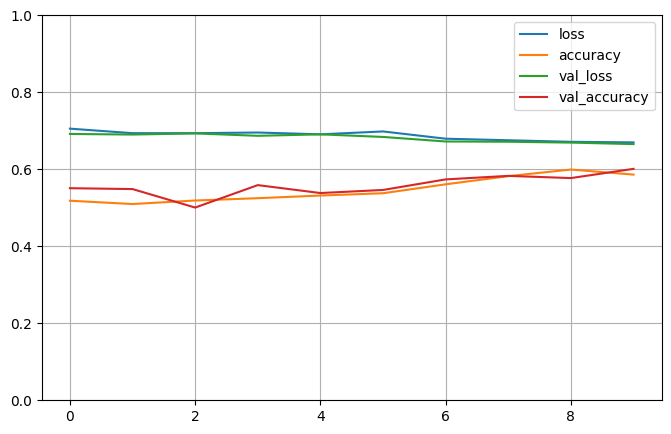


Testing # 2 5
2023-04-06 19:46:52.214451
2023-04-06 19:46:52.214824
PREDICT
2023-04-06 19:46:52.551212
Test 1:0 449:426 51.31%
Predict 1:0 564:311 64.46%
Test sizes (875, 4998) (875,)
Distrib of scores: 0.52602726 mean 0.13369514 std
Range of scores: 0.14452238 to 0.7286784
Score threshold 0.5
Confusion matrix
 [[194 232]
 [117 332]]
Normalized matrix
 [[0.22171429 0.26514286]
 [0.13371429 0.37942857]]
Correct scores pos:neg 92 85
Wrong scores pos:neg 51 40


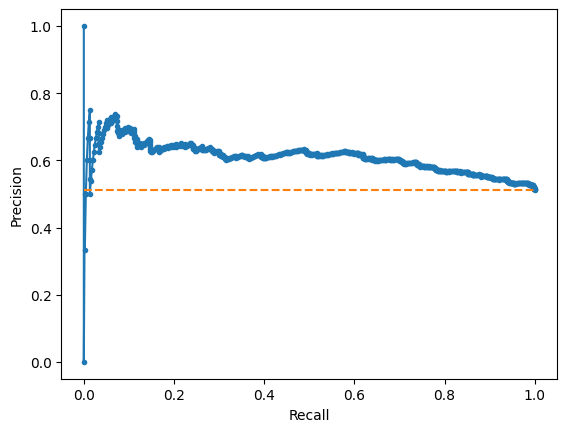

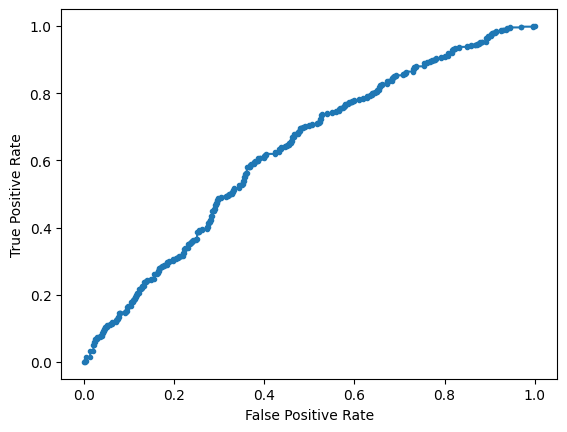

Accuracy: 60.11% Precision: 58.87% Recall: 73.94%
F1: 65.55% MCC: 0.2034
AUPRC: 60.86% AUROC: 62.80%
 accuracy [60.11428571428571]
 precision [58.86524822695035]
 recall [73.94209354120267]
 F1 [65.54787759131293]
 MCC [0.20344253307730595]
 AUPRC [60.863974420627656]
 AUROC [62.80440624444513]
2023-04-06 19:46:53.384860


In [89]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
# allids,allseq = loader.load_spectra(filepath)  # for MLP
allids,allseq = loader.load_sequence(filepath)  # for CNN and RNN
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)
           
        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [90]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 59.71% std 2.77
 precision mean 59.19% std 2.79
 recall mean 73.52% std 13.83
 F1 mean 64.80% std 6.02
 MCC mean 0.2000 std 0.0468
 AUPRC mean 62.14% std 1.51
 AUROC mean 63.90% std 1.82
 accuracy [[63.44827586206897], [58.93665158371041], [55.35924617196702], [55.168539325842694], [59.1324200913242], [59.63923337091319], [60.82949308755761], [62.7906976744186], [61.66097838452787], [60.11428571428571]]
 precision [[63.888888888888886], [56.32], [60.824742268041234], [53.72208436724566], [59.46462715105163], [59.163987138263664], [59.0032154340836], [61.811722912966246], [58.87850467289719], [58.86524822695035]]
 recall [[70.3056768558952], [79.63800904977376], [40.04524886877828], [94.33551198257081], [68.05251641137856], [77.96610169491525], [81.19469026548673], [76.82119205298014], [72.91666666666666], [73.94209354120267]]
 F1 [[66.94386694386694], [65.97938144329896], [48.294679399727144], [68.45849802371542], [63.46938775510205], [67.27605118829982], [68.34264432029